# Brain Tumor Classification

## Steps
  
1). Use old medical imaging powerpoints and assignments to generate todos for this project

2). Find a dataset on Kaggle that satisfies the same (very small if irrc) dataset qualties we used for that project

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

3). Apply preprocessing

4). Implement U-Net

In [1]:
import os
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load dataset paths/labels into a 2 column df


In [2]:
label_dict = {'glioma':0,'meningioma':1,'notumor':2,'pituitary':3}
label_dict_rev = {v:k for k,v in label_dict.items()}

def gather_dataset(path):
  path_list = [[os.path.join(path,folder,item),label_dict[folder]] for folder in os.listdir(path) for item in os.listdir(os.path.join(path,folder))]
  path_df = pd.DataFrame(path_list,columns=['image_path','label'])
  return path_df
    
non_test_df = gather_dataset('C:/Link_to_D_drive/datasets/Brain_Tumor_MRI/cleaned/Training/')
non_test_df = non_test_df.sample(frac=1.0)
# non_test_df = non_test_df.sample(frac=0.1)
test_df = gather_dataset('C:/Link_to_D_drive/datasets/Brain_Tumor_MRI/cleaned/Testing/')
test_df = test_df.sample(frac=1.0)
# test_df = test_df.sample(frac=0.01)
non_test_df['modified_image'] = [x.replace('cleaned','modified') for x in non_test_df['image_path']]
test_df['modified_image'] = [x.replace('cleaned','modified') for x in test_df['image_path']]


## Split data into folds

In [3]:

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(10)
folds = kfold.split(non_test_df['image_path'],non_test_df['label'])
fold_dict = {}
for i, (train_index, val_index) in enumerate(folds):
  fold_dict[i]={'train':train_index, 'validation':val_index}
def get_folds(df,foldnum,fold_dict):
  return df.iloc[fold_dict[i]['train']],df.iloc[fold_dict[i]['validation']]
print(len(get_folds(non_test_df,2,fold_dict)))
print(len(get_folds(non_test_df,2,fold_dict)[0]))
print(len(get_folds(non_test_df,2,fold_dict)[1]))


2
5141
571


## Preprocess Images
print 3 images with the preprocessing function 

There are some images that dont fit the mold. Like partial-heads. I wonder if i can filter these from the set

In [5]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from PIL import Image
from PIL import ImageOps
def load_image(image_path,label):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_image(image)
  one_hot_label = tf.one_hot(label, depth=4)
  return image,one_hot_label

def get_dataset(df,display=False):
  from PIL import Image
  import matplotlib.pyplot as plt
  # dataset = tf.data.Dataset.from_tensor_slices((df['image_path'].to_list(), df['label'].to_list()))
  dataset = tf.data.Dataset.from_tensor_slices((df['modified_image'].to_list(), df['label'].to_list()))
  dataset = dataset.map(load_image)
  dataset = dataset.batch(batch_size=1000)  
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  

  if display:
    iterator = iter(dataset)
    image= next(iterator)[0]
    image_np = image.numpy()
    for i in range(1,5):
      plt.imshow(image_np[i])
      plt.show()
    
  return dataset

#edit images on disk
import os
import shutil
def modify_images(df,train_or_test):
  #reset images
  original_path = 'C:/Link_to_D_drive/datasets/Brain_Tumor_MRI/cleaned/'+train_or_test
  modified_path = 'C:/Link_to_D_drive/datasets/Brain_Tumor_MRI/modified/'+train_or_test
  shutil.rmtree(modified_path)
  shutil.copytree(original_path,modified_path)
  
  for path in df['modified_image']:
  
    original_image = np.array(ImageOps.grayscale(Image.open(path)))
    image = original_image.copy()
    fourier = np.fft.fft2(image)
    shifted_fourier = np.fft.fftshift(fourier)

    #filter fft
    rows, cols = shifted_fourier.shape
    center_row, center_col = rows // 2, cols // 2
    radius = 50
    mask = np.zeros((rows, cols), dtype=np.uint8)
    filt =  cv2.circle(mask, (center_col, center_row), radius, 1, -1)
    filtered_fourier = shifted_fourier * filt
    filtered_image = np.fft.ifft2(filtered_fourier)
    filtered_image = np.real(filtered_image)
    filtered_image = np.log(1 + np.abs(filtered_image))
    filtered_image = filtered_image - np.min(filtered_image)
    filtered_image = filtered_image / np.max(filtered_image)
    filtered_image = filtered_image * 255
    filtered_image = filtered_image.astype(np.uint8)
    _,threshold_image = cv2.threshold(image, np.mean(image)+np.std(image), 255, cv2.THRESH_BINARY)
    threshold_image = threshold_image.astype(np.uint8)
    cv2.imwrite(path, cv2.cvtColor(threshold_image, cv2.COLOR_GRAY2BGR))
modify_images(non_test_df,'Training')
modify_images(test_df,'Testing')




tf.Tensor(214, shape=(), dtype=uint8)
tf.Tensor(255, shape=(), dtype=uint8)


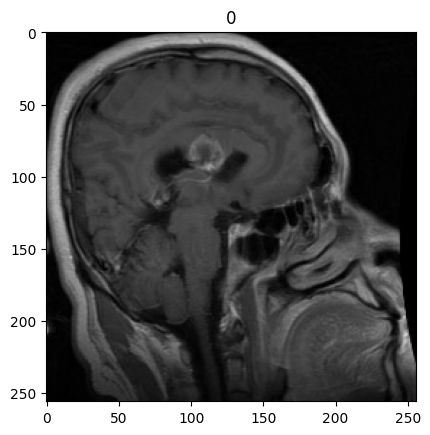

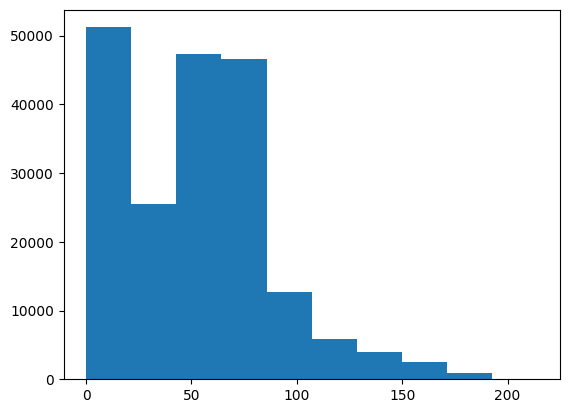

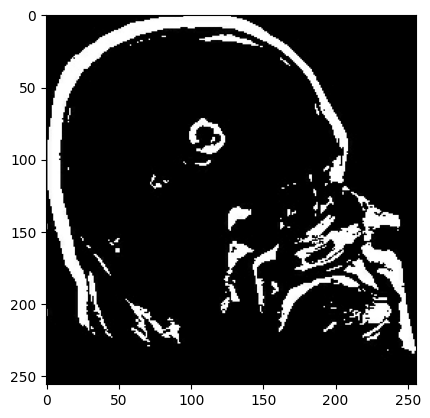

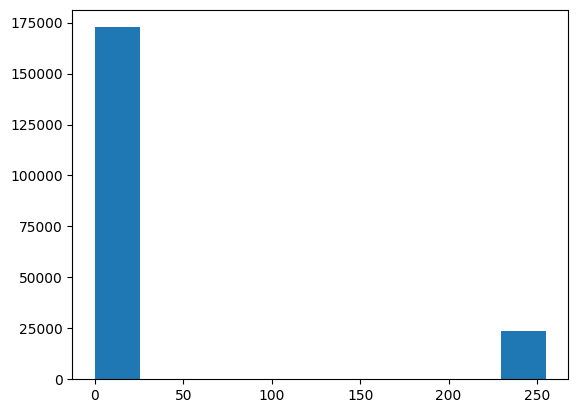

tf.Tensor(243, shape=(), dtype=uint8)
tf.Tensor(255, shape=(), dtype=uint8)


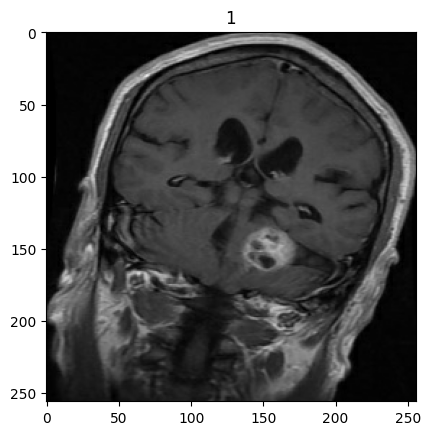

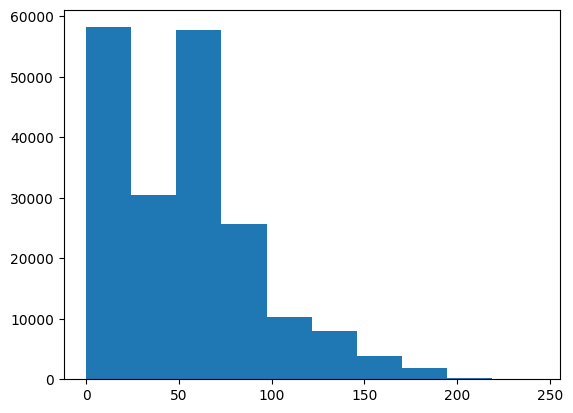

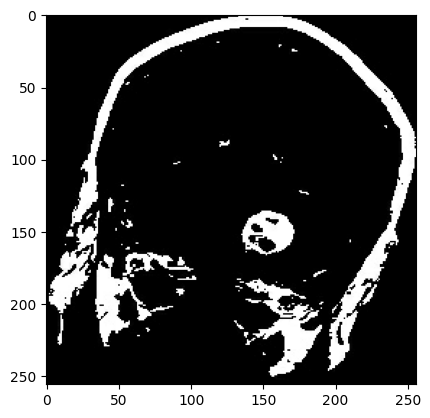

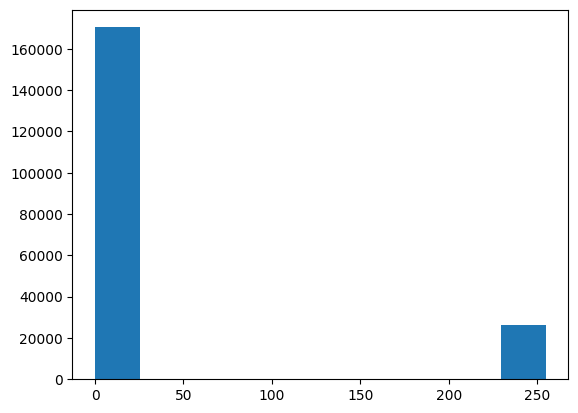

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(255, shape=(), dtype=uint8)


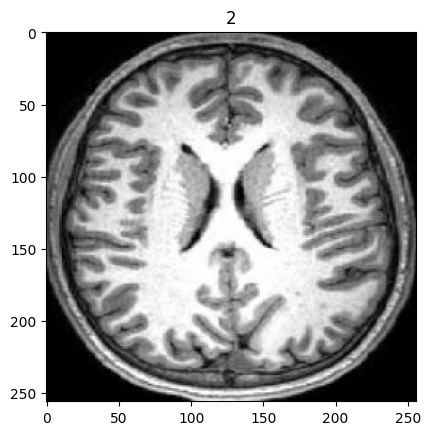

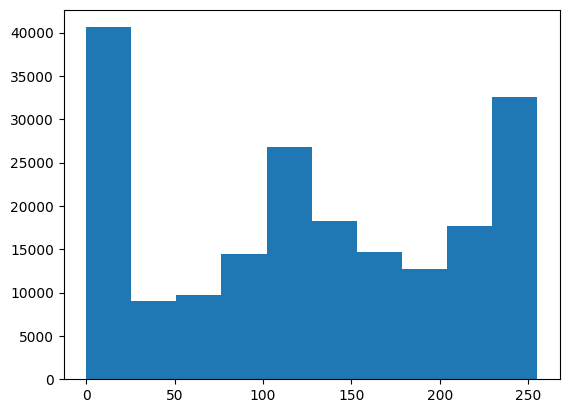

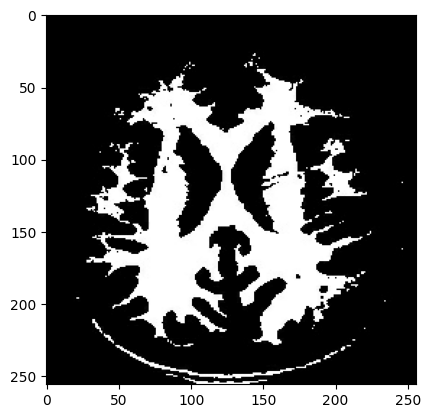

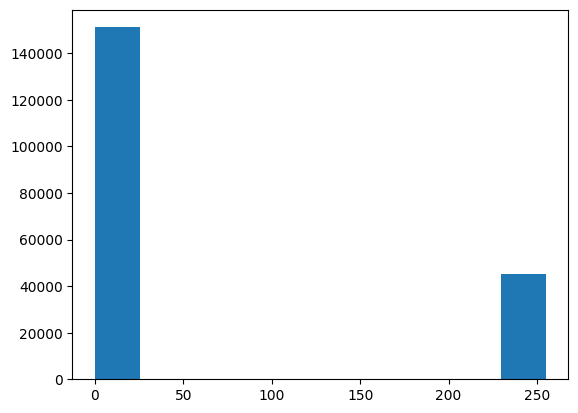

tf.Tensor(249, shape=(), dtype=uint8)
tf.Tensor(255, shape=(), dtype=uint8)


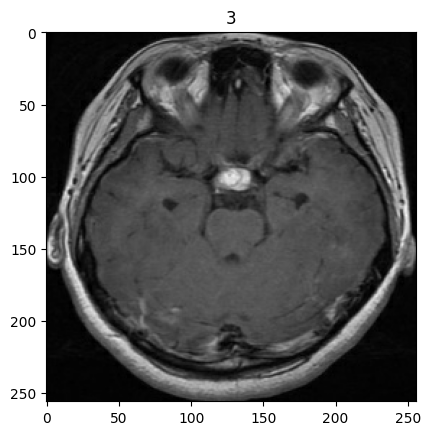

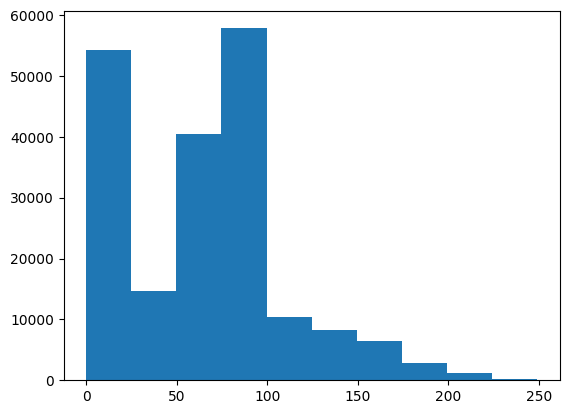

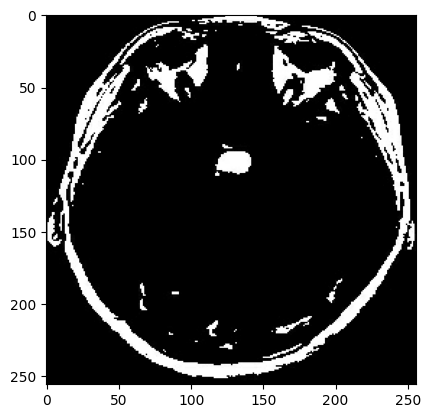

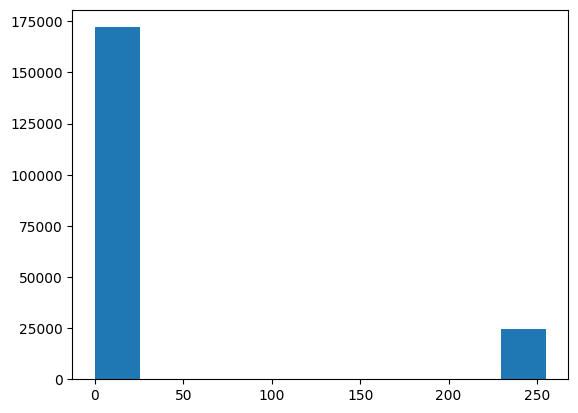

In [6]:
mini_groups = non_test_df.groupby('label')
for i,g in mini_groups:
  count=0
  for j,item in g.iterrows():
    image1 = load_image(item['image_path'],item['label'])[0]
    image2 = load_image(item['modified_image'],item['label'])[0]
    plt.title('Labeled',label_dict_rev[item['label']])
    plt.imshow(image1)
    plt.show()
    # flattened_image1= tf.reshape(image1, [-1])
    # flattened_image1 = flattened_image1.numpy().tolist()
    # plt.hist(flattened_image1)
    # plt.show()
    plt.imshow(image2)
    plt.show()
    # flattened_image2 = tf.reshape(image2, [-1])
    # flattened_image2 = flattened_image2.numpy().tolist()
    # plt.hist(flattened_image2)
    # plt.show()
    count+=1
    if count>0:
      break

## Train on ImageNet as benchmark, try and do better

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping



num_classes=4
early_stopping = EarlyStopping(monitor='val_loss', patience=7)
summary_arr = []
model_arr = []
for foldnum in range(len(fold_dict)):
  print('fold',foldnum)
  train_df,val_df = get_folds(non_test_df,foldnum,fold_dict)
  #apply transformations to datasets
  train_dataset = get_dataset(train_df)
  val_dataset = get_dataset(val_df)

  # Load the pre-trained ResNet50 model
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

  # Freeze the weights of the pre-trained layers
  for layer in base_model.layers:
      layer.trainable = False

  # Add your own classification head
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)

  # Create the final model
  model = Model(inputs=base_model.input, outputs=predictions)
  
  # Compile the model
  
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model on your dataset
  train_summary = model.fit(train_dataset, validation_data=val_dataset,callbacks=[early_stopping], epochs=100,verbose=0)
  print(train_summary)
  summary_arr.append(train_summary)
  model_arr.append(model)
  break

fold 0


## Evaluate Model

In [8]:
print(summary_arr[0].history.keys())
final_accuracy_arr = [x.history['val_accuracy'][-1] for x in summary_arr]
print(final_accuracy_arr)
final_model = model_arr[final_accuracy_arr.index(max(final_accuracy_arr))]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.8931698799133301]


In [9]:
test_dataset = get_dataset(test_df)
summary = final_model.evaluate(test_dataset)

2/2 [==============================] - 2s 624ms/step - loss: 0.2449 - accuracy: 0.9115


In [10]:
print(summary)

[0.24485346674919128, 0.9115179181098938]


In [11]:
def get_image(element, label):
  return element
def get_label(element, label):
  return label
test_dataset_images = test_dataset.map(get_image)
test_dataset_label = test_dataset.map(get_label)

pred = model.predict(test_dataset_images)


2/2 [==============================] - 2s 904ms/step


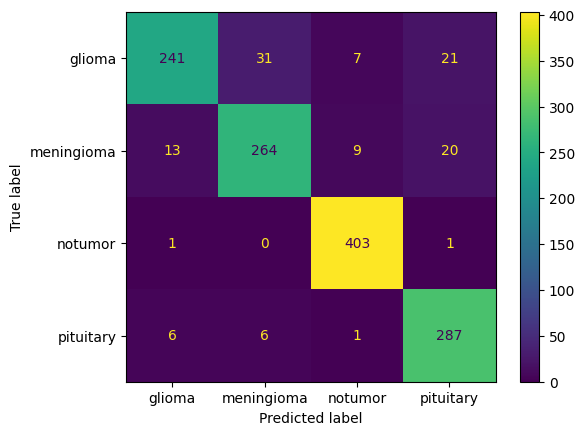

In [16]:
original_labels_list = []
for label in test_dataset_label:
# for label in reversed(list(test_dataset_label)):
  for item in label:
  # for item in reversed(list(label)):
    original_labels_list.append(np.argmax(item.numpy()))
new_pred = [np.argmax(x) for x in pred]
conf_matrix = confusion_matrix(original_labels_list,new_pred) #random confusion matrix, predictions are in the wrong order
graph = ConfusionMatrixDisplay(conf_matrix,display_labels=['glioma','meningioma','notumor','pituitary'])
graph.plot()
plt.show()

In [13]:
## Add results to original dataframes

In [ ]:
## Display 3 images from groups of correctly classified records 

In [ ]:
## Display 3 images groups of incorrectly classified records

In [ ]:
## Ideas
  #can i cluster the images into different views? Right now theyre mixed up